<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

from torchvision.transforms import Compose, ToTensor, Resize

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls /content/gdrive/MyDrive/TCC/code

2023-04-20_20:51:19_srcnn_avg_loss_0.1607180961540767
2023-04-22_19:32:41_srcnn_avg_loss_0.11218196153640747
2023-04-22_21:44:18_srcnn_avg_loss_0
2023-04-22_23:43:51_srcnn_avg_loss_0.09928497139896665
2023-04-23_02:07:37_srcnn_avg_loss_0.08752140934978213
models
srcnn_avg_loss_0.21316420606204442
srcnn_avg_loss_0.21332289704254695
SRCNN.ipynb


In [4]:
class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        n1 = 64
        n2 = 32

        self.model = nn.Sequential(

            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
                      kernel_size=(f1, f1), padding=(f1-1)//2),
            nn.ReLU(),

            # 3.1.2 Non-linear mapping
            nn.Conv2d(in_channels=n1, out_channels=n2,
                      kernel_size=(f2, f2), padding=(f2-1)//2),
            nn.ReLU(),

            # 3.1.3 Reconstruction
            nn.Conv2d(in_channels=n2, out_channels=3,
                      kernel_size=(f3, f3), padding=(f3-1)//2),
        )

        

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

def test_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    test_loss /= num_batches

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss


In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# garantir que é cuda
# assert device == "cuda"

In [8]:
# Instancianting the model
model = SRCNN()
model.to(device)

# hyperparameters
lr = 1e-5

In [9]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, transform = None, target_transform = None):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.file_lst = list(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return len(self.file_lst)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
        img_path = self.file_lst[idx]
        image = read_image(f"{self.img_dir}/{img_path}")
        image_x = image.detach().clone()
        image_y = image.detach().clone()
        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)
        return image_x.float() / 255, image_y.float() / 255

In [10]:
class ImageHelper:
    """
    A helper class for working with image data in PyTorch.
    """

    def __init__(self):
        """
        Initializes a new instance of the ImageHelper class.
        """
        return

    def show_tensor_as_image(self, tensor: torch.Tensor):
        """
        Displays an image represented as a PyTorch tensor.

        Args:
            tensor: A PyTorch tensor representing the image. The tensor should have shape (C, H, W),
                where C is the number of channels, H is the height, and W is the width.

        Returns:
            None
        """
        plt.figure()

        if torch.is_tensor(tensor):
          tensor_np = tensor.detach().numpy()
        else:
          tensor_np = tensor.numpy()
          
        plt.imshow(tensor_np.transpose((1, 2, 0)))
        plt.show()

ImageHelperInstance = ImageHelper()

In [11]:
transform_x = transforms.Compose([
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((33, 33), interpolation=Image.BICUBIC),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    # resize image to 256x256 and downsample by BICUBIC interpolation
    transforms.Resize((256, 256), interpolation=Image.BICUBIC),
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir="/content/gdrive/MyDrive/TCC/datasets/Flickr2K", transform=transform_x, target_transform=transform_y)
test_data_set = CustomImageDataset(
    img_dir="/content/gdrive/MyDrive/TCC/datasets/DIV2K_train_HR", transform=transform_x, target_transform=transform_y)

train_dataloader = DataLoader(train_data_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size=16)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(test_data_set)))

Training set has 2650 instances
Validation set has 850 instances


In [12]:
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


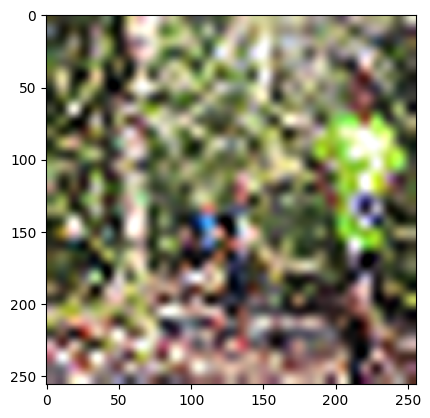

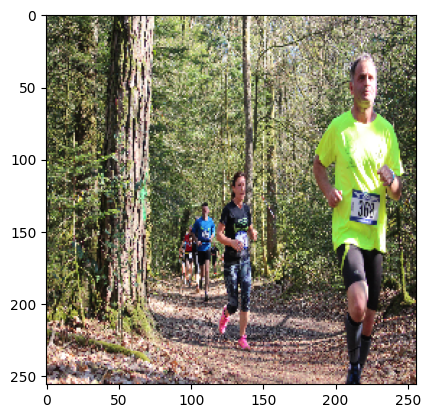

In [13]:
# example of training image
for X, y in train_dataloader:
    # print('X:')
    ImageHelperInstance.show_tensor_as_image(X[0])
    # print('y:')
    ImageHelperInstance.show_tensor_as_image(y[0])
    break


# CARREGAR O MODELO

In [23]:
import re

def get_epoch_number_from_path(s: str) -> int or None:
    epoch_pattern = r"epoch=(\d+)"
    match = re.search(epoch_pattern, s)

    if match:
        epoch_number = int(match.group(1))
        return epoch_number
    else:
        return None

In [24]:
# finding the most recent epoch model
directory = '/content/gdrive/My Drive/TCC/code/models/SRCNN/Flickr2K/'

most_recent_epoch = -1
model_load_path_name = ''
for filename in os.listdir(directory):
    epoch = get_epoch_number_from_path(filename)
    if epoch is not None and epoch > most_recent_epoch:
        most_recent_epoch = epoch
        model_load_path_name = os.path.join(directory, filename)

print("Most recent epoch:", most_recent_epoch)
print("Model load path name:", model_load_path_name)

Most recent epoch: 33
Model load path name: /content/gdrive/My Drive/TCC/code/models/SRCNN/Flickr2K/2023-04-26_20:54:42_epoch=33_srcnn_avg_loss_0.11652072560456064


In [25]:
if torch.cuda.is_available():
  model.load_state_dict(torch.load(model_load_path_name))
else:
  model.load_state_dict(torch.load(model_load_path_name, map_location=torch.device('cpu')))


# TREINANDO O MODELO E SALVANDO CADA EPOCH 

In [ ]:
%%time
train_loss = 0
test_loss = 0
starting_epoch = get_epoch_number_from_path(model_load_path_name)
epochs = 15
for index, t in enumerate(range(epochs)):
    if index == 0 and starting_epoch is None:
      current_epoch = 0
    elif starting_epoch >= 0:
      current_epoch = starting_epoch + t + 1 # (+1 because t starts at 0)
    else:
      current_epoch = 0

    print(f"Epoch {current_epoch}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)

    # saving each epoch, since it's taking forever to train
    date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
    model_save_path_name = f"/content/gdrive/My Drive/TCC/code/models/SRCNN/Flickr2K/{date}_epoch={current_epoch}_srcnn_avg_loss_{test_loss}"
    torch.save(model.state_dict(), model_save_path_name)
    
print("Done!")

Epoch 19
-------------------------------


  1%|          | 1/166 [35:20<97:10:50, 2120.31s/it]

loss: 0.149552  [    0/ 2650]


 61%|██████    | 101/166 [49:26<08:48,  8.13s/it]

loss: 0.172842  [ 1600/ 2650]


100%|██████████| 54/54 [11:14<00:00, 12.49s/it]


Test Error: 
 Avg loss: 0.162290 

Epoch 20
-------------------------------


  1%|          | 1/166 [00:08<23:25,  8.52s/it]

loss: 0.194814  [    0/ 2650]


 61%|██████    | 101/166 [13:26<08:42,  8.03s/it]

loss: 0.145126  [ 1600/ 2650]


100%|██████████| 54/54 [04:27<00:00,  4.95s/it]


Test Error: 
 Avg loss: 0.158861 

Epoch 21
-------------------------------


  1%|          | 1/166 [00:08<22:13,  8.08s/it]

loss: 0.171776  [    0/ 2650]


 61%|██████    | 101/166 [13:30<08:36,  7.94s/it]

loss: 0.134190  [ 1600/ 2650]


100%|██████████| 54/54 [04:27<00:00,  4.95s/it]


Test Error: 
 Avg loss: 0.155447 

Epoch 22
-------------------------------


  1%|          | 1/166 [00:07<20:02,  7.29s/it]

loss: 0.154309  [    0/ 2650]


 61%|██████    | 101/166 [13:35<10:51, 10.03s/it]

loss: 0.151095  [ 1600/ 2650]


100%|██████████| 54/54 [04:28<00:00,  4.97s/it]


Test Error: 
 Avg loss: 0.152048 

Epoch 23
-------------------------------


  1%|          | 1/166 [00:07<20:10,  7.34s/it]

loss: 0.158330  [    0/ 2650]


 61%|██████    | 101/166 [13:37<08:30,  7.86s/it]

loss: 0.140544  [ 1600/ 2650]


100%|██████████| 54/54 [04:17<00:00,  4.77s/it]


Test Error: 
 Avg loss: 0.148672 

Epoch 24
-------------------------------


  1%|          | 1/166 [00:08<24:32,  8.92s/it]

loss: 0.147416  [    0/ 2650]


 61%|██████    | 101/166 [13:40<08:27,  7.81s/it]

loss: 0.153865  [ 1600/ 2650]


100%|██████████| 54/54 [04:20<00:00,  4.83s/it]


Test Error: 
 Avg loss: 0.145316 

Epoch 25
-------------------------------


  1%|          | 1/166 [00:08<23:27,  8.53s/it]

loss: 0.147830  [    0/ 2650]


 61%|██████    | 101/166 [13:35<08:26,  7.80s/it]

loss: 0.142415  [ 1600/ 2650]


100%|██████████| 54/54 [04:25<00:00,  4.92s/it]


Test Error: 
 Avg loss: 0.141986 

Epoch 26
-------------------------------


  1%|          | 1/166 [00:07<20:20,  7.39s/it]

loss: 0.126331  [    0/ 2650]


 61%|██████    | 101/166 [13:52<08:36,  7.94s/it]

loss: 0.142222  [ 1600/ 2650]


100%|██████████| 54/54 [04:17<00:00,  4.77s/it]


Test Error: 
 Avg loss: 0.138683 

Epoch 27
-------------------------------


  1%|          | 1/166 [00:08<23:23,  8.51s/it]

loss: 0.149634  [    0/ 2650]


 61%|██████    | 101/166 [13:47<08:46,  8.10s/it]

loss: 0.147200  [ 1600/ 2650]


100%|██████████| 54/54 [04:22<00:00,  4.86s/it]


Test Error: 
 Avg loss: 0.135406 

Epoch 28
-------------------------------


  1%|          | 1/166 [00:07<21:28,  7.81s/it]

loss: 0.141450  [    0/ 2650]


 61%|██████    | 101/166 [13:39<08:43,  8.05s/it]

loss: 0.136341  [ 1600/ 2650]


100%|██████████| 54/54 [04:26<00:00,  4.94s/it]


Test Error: 
 Avg loss: 0.132164 

Epoch 29
-------------------------------


  1%|          | 1/166 [00:08<23:28,  8.54s/it]

loss: 0.119548  [    0/ 2650]


 61%|██████    | 101/166 [13:44<08:38,  7.97s/it]

loss: 0.130640  [ 1600/ 2650]


100%|██████████| 54/54 [04:18<00:00,  4.79s/it]


Test Error: 
 Avg loss: 0.128956 

Epoch 30
-------------------------------


  1%|          | 1/166 [00:07<20:14,  7.36s/it]

loss: 0.134487  [    0/ 2650]


 61%|██████    | 101/166 [13:48<08:59,  8.31s/it]

loss: 0.119041  [ 1600/ 2650]


100%|██████████| 54/54 [04:26<00:00,  4.93s/it]


Test Error: 
 Avg loss: 0.125784 

Epoch 31
-------------------------------


  1%|          | 1/166 [00:07<21:11,  7.71s/it]

loss: 0.151358  [    0/ 2650]


 61%|██████    | 101/166 [13:29<08:32,  7.88s/it]

loss: 0.103576  [ 1600/ 2650]


100%|██████████| 54/54 [04:24<00:00,  4.89s/it]


Test Error: 
 Avg loss: 0.122653 

Epoch 32
-------------------------------


  1%|          | 1/166 [00:09<25:04,  9.12s/it]

loss: 0.117490  [    0/ 2650]


 61%|██████    | 101/166 [13:31<08:18,  7.68s/it]

loss: 0.115362  [ 1600/ 2650]


100%|██████████| 54/54 [04:17<00:00,  4.77s/it]


Test Error: 
 Avg loss: 0.119564 

Epoch 33
-------------------------------


  1%|          | 1/166 [00:07<21:11,  7.71s/it]

loss: 0.136925  [    0/ 2650]


 61%|██████    | 101/166 [13:39<08:57,  8.27s/it]

loss: 0.136918  [ 1600/ 2650]


100%|██████████| 54/54 [04:32<00:00,  5.05s/it]

Test Error: 
 Avg loss: 0.116521 

Done!
CPU times: user 4h 41min 27s, sys: 1h 44min 29s, total: 6h 25min 56s
Wall time: 7h 23min 59s


255


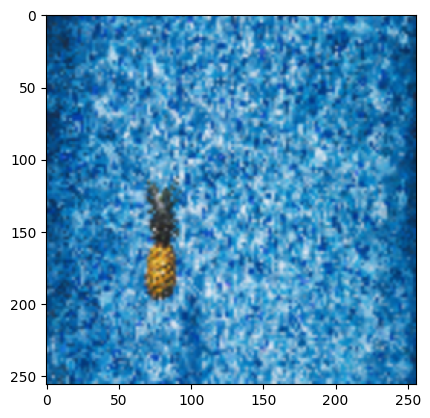

In [14]:
new_image = Image.open('/content/gdrive/MyDrive/TCC/datasets/DIV2K_valid_HR/0797.png')
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((128, 128), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(np.array(new_image).max())
ImageHelperInstance.show_tensor_as_image(new_image_lr)


In [15]:
new_image_lr.dtype

torch.float32

In [16]:
new_image_lr.max()

tensor(0.9600)

In [26]:
new_image_sr = model(new_image_lr.to(device))

In [27]:
new_image_sr.max()

tensor(0.3635, grad_fn=<MaxBackward1>)

In [28]:
# new_image_sr_mul = torch.mul(new_image_sr, 0.9600/0.1203)
# new_image_sr_mul.max()

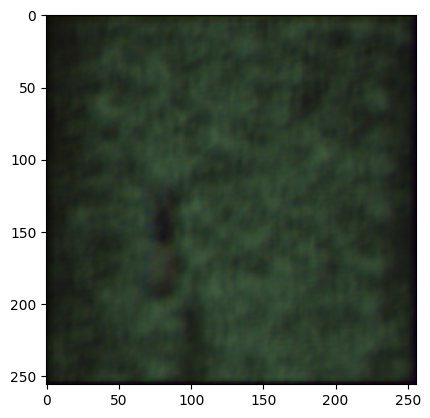

In [29]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

# SALVAR MODELO


In [30]:
# date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
# model_save_path_name = f"/content/gdrive/My Drive/TCC/code/models/SRCNN/Flickr2K/{date}_srcnn_avg_loss_{test_loss}"
# torch.save(model.state_dict(), model_save_path_name)

In [31]:
new_image_sr = model(new_image_lr.to(device))

In [32]:
new_image_sr.dtype

torch.float32

In [33]:
new_image_sr.max()

tensor(0.3635, grad_fn=<MaxBackward1>)

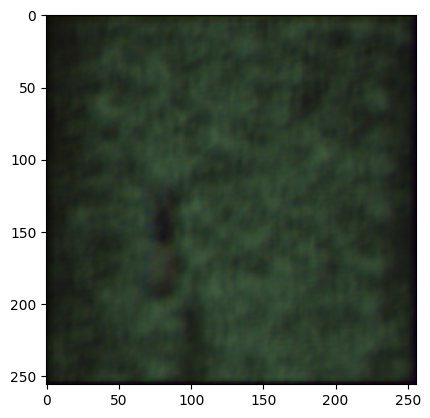

In [34]:

import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()